In [2]:
import numpy as np
import pandas as pd
from scipy import sparse
import pymorphy2
import sys
sys.path.insert(0, '/home/mlepekhin/Non-thematic-Text-Classification/code/allennlp_experiments')
from data_processing import *
from models import *
from interpretation import *

In [3]:
genre_list = ['A1', 'A4', 'A7', 'A8', 'A9', 'A11', 'A12', 'A13', 'A14', 'A16', 'A17', 'A20']

def get_df_from_file(filename):
    df = pd.DataFrame()
    
    with open(filename) as fin:
        for line in fin:
            best_genre = genre_list[np.argmax(list(map(float, line.split('\t')[1:13])))]
            if best_genre not in ['A13', 'A20']:
                df = df.append({'text': ' '.join(line.split('\t')[13].split()[1:]), 'target': best_genre}, ignore_index=True)
    return df

df_names = [1, 2, 3, 4, 5, 6, 7, 8]
df_list = []

for df_name in df_names:
    df_list.append(get_df_from_file(f'/home/mlepekhin/data/manual_genres/{df_name}.csv'))

In [4]:
MODELS_DIR = '/home/mlepekhin/models'

transformer_model1 = 'xlm-roberta-base'
MODEL_ID1 = 'allennlp_xlm_roberta_enru_attacked_50_3'
CHECKPOINTS_DIR1 = pathjoin(MODELS_DIR, MODEL_ID1, 'checkpoints')
BEST_MODEL1 = pathjoin(CHECKPOINTS_DIR1, 'best.th')

transformer_model2 = 'DeepPavlov/rubert-base-cased'
MODEL_ID2 = 'rubert_enru_attacked_50' 
CHECKPOINTS_DIR2 = pathjoin(MODELS_DIR, MODEL_ID2, 'checkpoints')
BEST_MODEL2 = pathjoin(CHECKPOINTS_DIR2, 'best.th')

MAX_TOKENS = 512

In [5]:
!gpustat

seven                Mon Mar 15 18:17:16 2021  440.64
[0] TITAN RTX        | 38'C,   0 % |  4769 / 24220 MB | sharuev(2791M) sharuev(1965M)
[1] TITAN RTX        | 86'C,  98 % |  8342 / 24220 MB | cwb(2651M) cwb(2679M) cwb(3001M)
[2] TITAN RTX        | 34'C,   0 % |    11 / 24220 MB |
[3] TITAN RTX        | 87'C,  99 % |  9928 / 24220 MB | cwb(3411M) cwb(3063M) cwb(3443M)


In [6]:
vocab1 = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID1, 'vocab'))
model1 = build_pool_transformer_model(vocab1, transformer_model1)
model1.load_state_dict(torch.load(BEST_MODEL1, map_location='cpu'))

03152021 18:17:16|INFO|allennlp.data.vocabulary| Loading token dictionary from /home/mlepekhin/models/allennlp_xlm_roberta_enru_attacked_50_3/vocab.
03152021 18:17:16|INFO|filelock| Lock 140377516386816 acquired on /home/mlepekhin/models/allennlp_xlm_roberta_enru_attacked_50_3/vocab/.lock
03152021 18:17:16|INFO|filelock| Lock 140377516386816 released on /home/mlepekhin/models/allennlp_xlm_roberta_enru_attacked_50_3/vocab/.lock


Building the model


03152021 18:17:17|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at /home/mlepekhin/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
03152021 18:17:17|INFO|transformers.configuration_utils| Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 250002
}

03152021 18:17:17|INFO|transformers.modeling_util

<All keys matched successfully>

In [7]:
id_to_label1 = vocab1.get_index_to_token_vocabulary('labels')
label_to_id1 = vocab1.get_token_to_index_vocabulary('labels')
print(id_to_label1)
print(id_to_label1.values())

{0: 'A8', 1: 'A1', 2: 'A11', 3: 'A12', 4: 'A7', 5: 'A16', 6: 'A17', 7: 'A4', 8: 'A14', 9: 'A9', 10: 'A22'}
dict_values(['A8', 'A1', 'A11', 'A12', 'A7', 'A16', 'A17', 'A4', 'A14', 'A9', 'A22'])


In [8]:
vocab2 = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID2, 'vocab'))
model2 = build_transformer_model(vocab2, transformer_model2)
model2.load_state_dict(torch.load(BEST_MODEL2, map_location='cpu'))

03152021 18:17:33|INFO|allennlp.data.vocabulary| Loading token dictionary from /home/mlepekhin/models/rubert_enru_attacked_50/vocab.
03152021 18:17:33|INFO|filelock| Lock 140383224876960 acquired on /home/mlepekhin/models/rubert_enru_attacked_50/vocab/.lock
03152021 18:17:33|INFO|filelock| Lock 140383224876960 released on /home/mlepekhin/models/rubert_enru_attacked_50/vocab/.lock


Building the model


03152021 18:17:33|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/DeepPavlov/rubert-base-cased/config.json from cache at /home/mlepekhin/.cache/torch/transformers/b1ea51df212fa070e3a8a7d04dedb4800621e5a5bf504ecdb305faa622b46aa0.41d1cb30da8abef9028a44a17bd9c152daca0bd46e409bc271f324a28d109450
03152021 18:17:33|INFO|transformers.configuration_utils| Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "po

<All keys matched successfully>

In [9]:
id_to_label2 = vocab2.get_index_to_token_vocabulary('labels')
label_to_id2 = vocab2.get_token_to_index_vocabulary('labels')
print(id_to_label2)
print(id_to_label2.values())

{0: 'A8', 1: 'A1', 2: 'A11', 3: 'A12', 4: 'A7', 5: 'A16', 6: 'A17', 7: 'A4', 8: 'A14', 9: 'A9', 10: 'A22'}
dict_values(['A8', 'A1', 'A11', 'A12', 'A7', 'A16', 'A17', 'A4', 'A14', 'A9', 'A22'])


In [10]:
dataset_reader1 = build_transformer_dataset_reader(transformer_model1, MAX_TOKENS)
predictor1 = TextClassifierPredictor(model1, dataset_reader=dataset_reader1)

03152021 18:17:47|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at /home/mlepekhin/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
03152021 18:17:47|INFO|transformers.configuration_utils| Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 250002
}

03152021 18:17:48|INFO|transformers.tokenization_

In [11]:
dataset_reader2 = build_transformer_dataset_reader(transformer_model2, MAX_TOKENS)
predictor2 = TextClassifierPredictor(model2, dataset_reader=dataset_reader2)

03152021 18:17:54|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/DeepPavlov/rubert-base-cased/config.json from cache at /home/mlepekhin/.cache/torch/transformers/b1ea51df212fa070e3a8a7d04dedb4800621e5a5bf504ecdb305faa622b46aa0.41d1cb30da8abef9028a44a17bd9c152daca0bd46e409bc271f324a28d109450
03152021 18:17:54|INFO|transformers.configuration_utils| Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "po

In [12]:
from tqdm import tqdm

'''
all_predicted_probs1 = []
all_predicted_labels1 = []

for df in tqdm(df_list):
    predicted_probs = [predictor1.predict(text)['probs'] for text in df.text.values]
    predicted_labels = [id_to_label1[np.argmax(probs)] for probs in predicted_probs]
    all_predicted_probs1.append(predicted_probs[:])
    all_predicted_labels1.append(predicted_labels[:])'''

"\nall_predicted_probs1 = []\nall_predicted_labels1 = []\n\nfor df in tqdm(df_list):\n    predicted_probs = [predictor1.predict(text)['probs'] for text in df.text.values]\n    predicted_labels = [id_to_label1[np.argmax(probs)] for probs in predicted_probs]\n    all_predicted_probs1.append(predicted_probs[:])\n    all_predicted_labels1.append(predicted_labels[:])"

In [13]:
import pickle
#pickle.dump(all_predicted_probs1, open('xlm_roberta_probs_50_3.pkl', 'wb'))
all_predicted_probs1 = pickle.load(open('xlm_roberta_probs_50_3.pkl', 'rb'))

In [14]:
'''all_predicted_probs2 = []
all_predicted_labels2 = []

for df in tqdm(df_list):
    predicted_probs = [predictor2.predict(text)['probs'] for text in df.text.values]
    predicted_labels = [id_to_label2[np.argmax(probs)] for probs in predicted_probs]
    all_predicted_probs2.append(predicted_probs[:])
    all_predicted_labels2.append(predicted_labels[:])'''

"all_predicted_probs2 = []\nall_predicted_labels2 = []\n\nfor df in tqdm(df_list):\n    predicted_probs = [predictor2.predict(text)['probs'] for text in df.text.values]\n    predicted_labels = [id_to_label2[np.argmax(probs)] for probs in predicted_probs]\n    all_predicted_probs2.append(predicted_probs[:])\n    all_predicted_labels2.append(predicted_labels[:])"

In [15]:
#pickle.dump(all_predicted_probs2, open('rubert_k50_probs.pkl', 'wb'))
all_predicted_probs2 = pickle.load(open('rubert_k50_probs.pkl', 'rb'))

In [16]:
from sklearn.metrics import accuracy_score

all_targets = np.concatenate([df.target.values for df in df_list])
all_texts = np.concatenate([df.text.values for df in df_list])
all_names = np.concatenate([[df_name] * len(df) for df, df_name in zip(df_list, df_names)])

#all_predictions1 = np.concatenate(all_predicted_labels1)
total_probs1 = np.concatenate(all_predicted_probs1)

#all_predictions2 = np.concatenate(all_predicted_labels2)
total_probs2 = np.concatenate(all_predicted_probs2)

In [17]:
unique_labels = sorted(np.unique(pd.read_csv('/home/mlepekhin/data/en_train').target.values))

In [18]:
from classic_models import *

In [19]:
new_lr, new_vectorizer = load_model('lr_enru_noattacked')

In [20]:
id_to_label3 = {label_id: label for label_id, label in enumerate(new_lr.classes_)}
label_to_id3 = {label: label_id for label_id, label in enumerate(new_lr.classes_)}

In [21]:
all_predicted_probs3 = []
all_predicted_labels3 = []

for df in tqdm(df_list):
    predicted_probs = new_lr.predict_proba(new_vectorizer.transform(df.text.values))
    predicted_labels = [id_to_label3[np.argmax(probs)] for probs in predicted_probs]
    all_predicted_probs3.append(predicted_probs[:])
    all_predicted_labels3.append(predicted_labels[:])

100%|██████████| 8/8 [00:14<00:00,  1.86s/it]


In [22]:
total_probs3 = np.concatenate(all_predicted_probs3)

In [25]:
total_probs4 = np.load('../../../../textattack_experiments/ru_lstm_attention/livejournal_probs.npy')

In [26]:
def test_ensemble(alpha_xlm_roberta, alpha_rubert, alpha_lr, show_detailed_statistics=False):
    alpha_lstm = 1 - alpha_xlm_roberta - alpha_rubert
    normalized_probs1 = np.zeros_like(total_probs1).astype(float)
    normalized_probs2 = np.zeros_like(total_probs2).astype(float)
    normalized_probs3 = np.zeros_like(total_probs3).astype(float)
    normalized_probs4 = np.zeros_like(total_probs4).astype(float)
    
    for label_id, label in enumerate(unique_labels):
        normalized_probs1[:, label_id] = total_probs1[:, label_to_id1[label]]
        normalized_probs2[:, label_id] = total_probs2[:, label_to_id2[label]]
        normalized_probs3[:, label_id] = total_probs3[:, label_to_id3[label]]
    normalized_probs4 = total_probs4
        
    ensemble_probs = alpha_xlm_roberta * normalized_probs1
    ensemble_probs += alpha_rubert * normalized_probs2
    ensemble_probs += alpha_lr * normalized_probs3
    ensemble_probs += alpha_lstm * normalized_probs4
    
    
    ensemble_predictions = [unique_labels[label_id] for label_id in np.argmax(ensemble_probs, axis=1)]
    #print(ensemble_predictions)
    #print(all_targets)
    total_accuracy = accuracy_score(ensemble_predictions, all_targets)
    #print('overall accuracy', total_accuracy)
    
    if show_detailed_statistics:
        calc_classifier_metrics(np.array(ensemble_predictions), all_targets)
        plot_confusion_matrix(np.array(ensemble_predictions), all_targets)
        plt.show()
    
    return total_accuracy

/home/mlepekhin/Non-thematic-Text-Classification/code/allennlp_experiments/interpretation.py:90: RuntimeWarning: invalid value encountered in true_divide
  normed_cm = (cm.T / sums).T
03152021 18:19:07|INFO|numexpr.utils| Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
03152021 18:19:07|INFO|numexpr.utils| NumExpr defaulting to 8 threads.


label (argum) f1_score 0.5823293172690762 precision 0.5631067961165048 recall 0.6029106029106029
label (fictive) f1_score 0.6888888888888889 precision 0.7701863354037267 recall 0.6231155778894473
label (instruct) f1_score 0.6439628482972136 precision 0.7938931297709924 recall 0.5416666666666666
label (reporting) f1_score 0.9366013071895424 precision 0.9293125810635539 recall 0.9440052700922266
label (legal) f1_score 0.6511627906976745 precision 0.4827586206896552 recall 1.0
label (personal) f1_score 0.757439134355275 precision 0.7046979865771812 recall 0.8187134502923976
label (commercial) f1_score 0.31088082901554404 precision 0.24 recall 0.4411764705882353
label (research) f1_score 0.37499999999999994 precision 0.5 recall 0.3
label (info) f1_score 0.5686900958466454 precision 0.6267605633802817 recall 0.52046783625731
label (eval) f1_score 0.5609065155807365 precision 0.5892857142857143 recall 0.5351351351351351
accuracy 0.7635800731775964


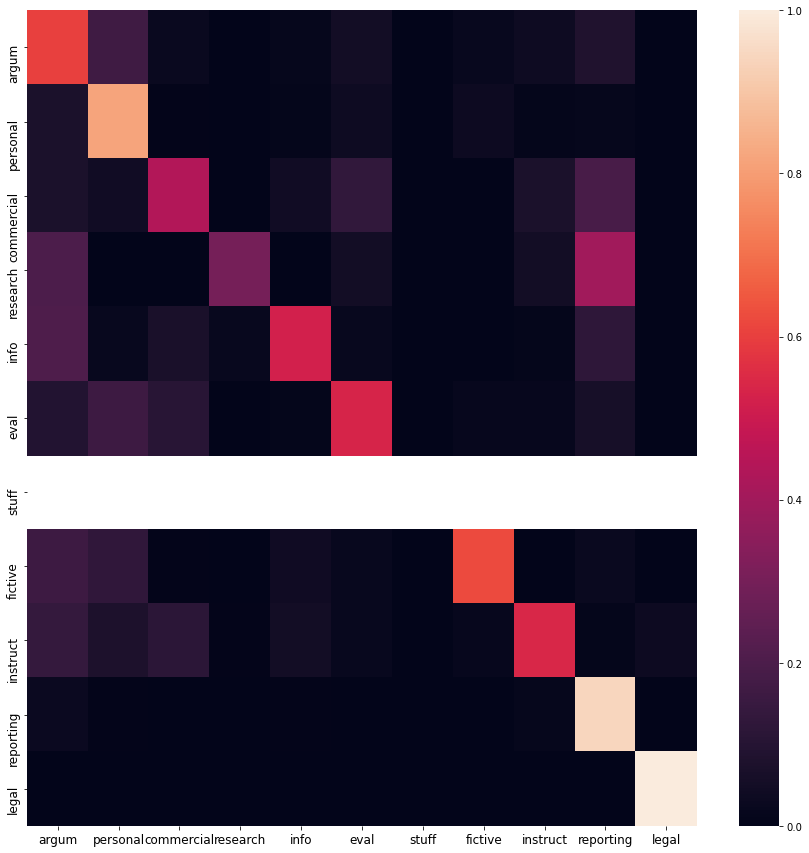

0.7635800731775964

In [27]:
test_ensemble(1, 0, 0, show_detailed_statistics=True)

label (argum) f1_score 0.45859872611464964 precision 0.5921052631578947 recall 0.37422037422037424
label (fictive) f1_score 0.6521739130434782 precision 0.7100591715976331 recall 0.6030150753768844
label (instruct) f1_score 0.611842105263158 precision 0.8303571428571429 recall 0.484375
label (reporting) f1_score 0.9238927011852777 precision 0.8773696682464455 recall 0.9756258234519104
label (legal) f1_score 0.5 precision 0.3333333333333333 recall 1.0
label (personal) f1_score 0.717900656044986 precision 0.6913357400722022 recall 0.746588693957115
label (commercial) f1_score 0.23754789272030652 precision 0.16062176165803108 recall 0.45588235294117646
label (research) f1_score 0.13793103448275865 precision 0.2222222222222222 recall 0.1
label (info) f1_score 0.535483870967742 precision 0.5971223021582733 recall 0.4853801169590643
label (eval) f1_score 0.47596153846153844 precision 0.42857142857142855 recall 0.5351351351351351
accuracy 0.7258654658035463


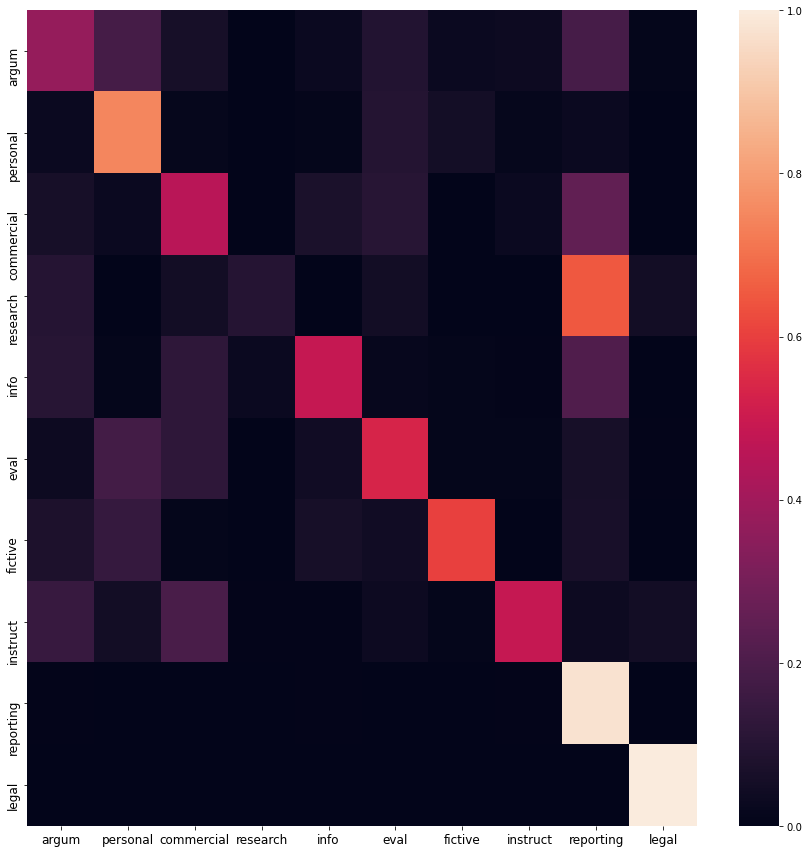

0.7258654658035463

In [28]:
test_ensemble(0, 1, 0, show_detailed_statistics=True)

label (argum) f1_score 0.4772545889864326 precision 0.3873056994818653 recall 0.6216216216216216
label (fictive) f1_score 0.25833333333333336 precision 0.7560975609756098 recall 0.15577889447236182
label (instruct) f1_score 0.2392776523702032 precision 0.8983050847457628 recall 0.13802083333333334
label (reporting) f1_score 0.8669581511555278 precision 0.8242280285035629 recall 0.9143610013175231
label (legal) f1_score 0.21621621621621623 precision 0.13333333333333333 recall 0.5714285714285714
label (personal) f1_score 0.6350626118067978 precision 0.5867768595041323 recall 0.6920077972709552
label (commercial) f1_score 0.18823529411764706 precision 0.1568627450980392 recall 0.23529411764705882
label (research) f1_score 0.07142857142857144 precision 0.125 recall 0.05
label (info) f1_score 0.03225806451612903 precision 0.2 recall 0.017543859649122806
label (eval) f1_score 0.29081632653061223 precision 0.2753623188405797 recall 0.3081081081081081
accuracy 0.6222910216718266


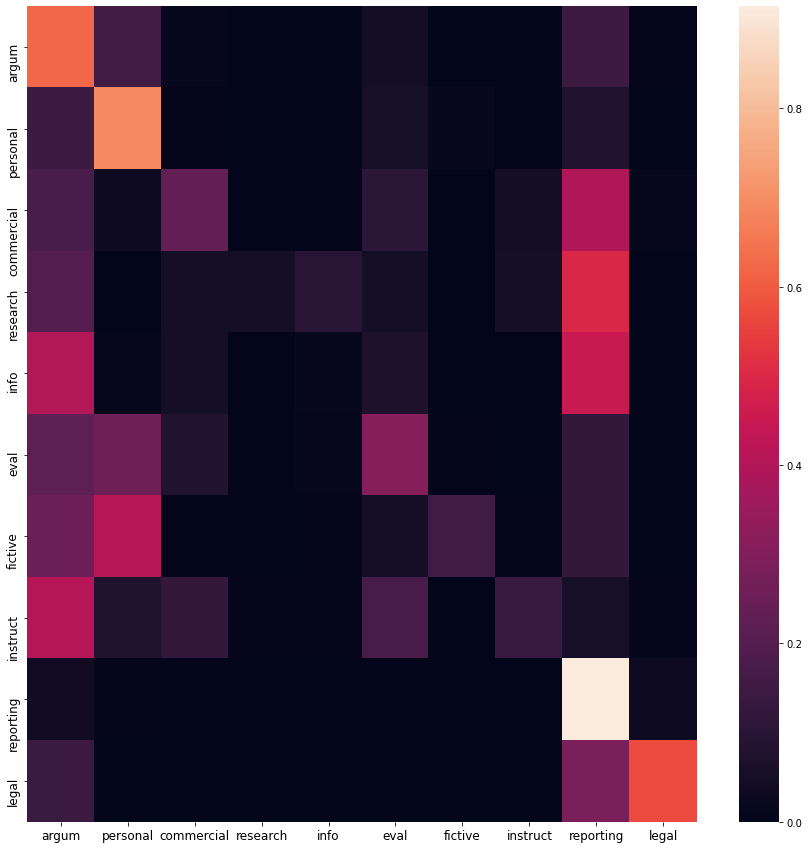

0.6222910216718266

In [29]:
test_ensemble(0, 0, 1, show_detailed_statistics=True)

label (argum) f1_score 0.4548959136468774 precision 0.36151960784313725 recall 0.6133056133056133
label (fictive) f1_score 0.18852459016393444 precision 0.5111111111111111 recall 0.11557788944723618
label (instruct) f1_score 0.08888888888888888 precision 0.8571428571428571 recall 0.046875
label (reporting) f1_score 0.8574132492113565 precision 0.822639225181598 recall 0.8952569169960475
label (legal) f1_score 0.14285714285714285 precision 0.08928571428571429 recall 0.35714285714285715
label (personal) f1_score 0.5963302752293579 precision 0.5632582322357019 recall 0.6335282651072125
label (commercial) f1_score 0.16949152542372883 precision 0.2 recall 0.14705882352941177
label (research) f1_score 0.0 precision 0.0 recall 0.0
label (info) f1_score 0.020100502512562814 precision 0.07142857142857142 recall 0.011695906432748537
label (eval) f1_score 0.2379958246346555 precision 0.19387755102040816 recall 0.3081081081081081
accuracy 0.5893611032929919


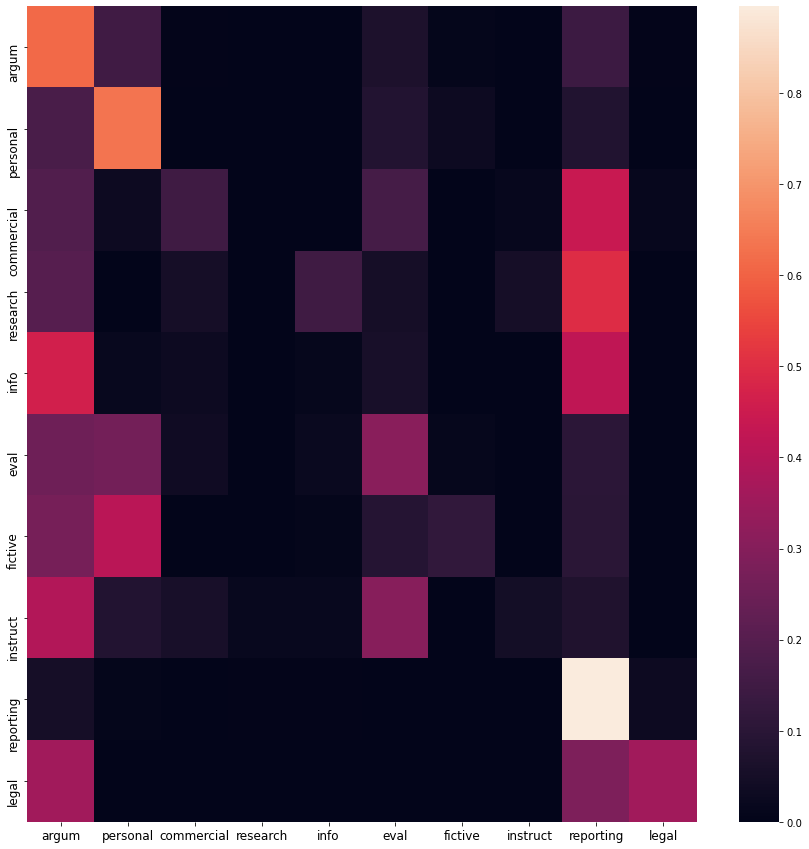

0.5893611032929919

In [30]:
test_ensemble(0, 0, 0, show_detailed_statistics=True)

In [31]:
best_coeff = (0, 0)
best_accuracy = 0

for i in np.linspace(0, 1, 100):
    for j in np.linspace(0, 1-i, 100):
        cur_acc = test_ensemble(i, j, 0)
        if cur_acc > best_accuracy:
            best_accuracy = cur_acc
            best_coeff = (i, j, 0)

(0.5656565656565657, 0.2632384450566268, 0)
label (argum) f1_score 0.5895372233400402 precision 0.571150097465887 recall 0.6091476091476091
label (fictive) f1_score 0.7065527065527065 precision 0.8157894736842105 recall 0.6231155778894473
label (instruct) f1_score 0.6591639871382637 precision 0.8613445378151261 recall 0.5338541666666666
label (reporting) f1_score 0.9390519187358917 precision 0.919772583701832 recall 0.9591567852437418
label (legal) f1_score 0.6666666666666666 precision 0.5 recall 1.0
label (personal) f1_score 0.7608695652173912 precision 0.7106598984771574 recall 0.8187134502923976
label (commercial) f1_score 0.31958762886597936 precision 0.24603174603174602 recall 0.45588235294117646
label (research) f1_score 0.26666666666666666 precision 0.4 recall 0.2
label (info) f1_score 0.5808580858085809 precision 0.6666666666666666 recall 0.5146198830409356
label (eval) f1_score 0.5698630136986301 precision 0.5777777777777777 recall 0.5621621621621622
accuracy 0.770897832817337

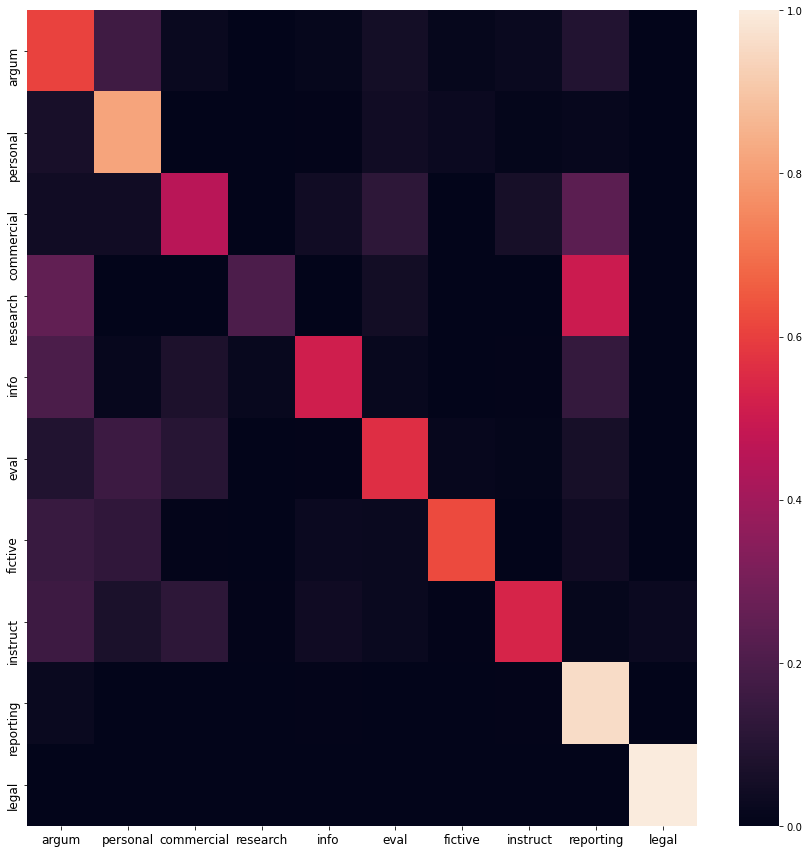

0.7708978328173375

In [33]:
print(best_coeff)
test_ensemble(*best_coeff, show_detailed_statistics=True)